In [1]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

In [2]:
file_path = "master_9_sites.csv"


master_9_sites = pd.read_csv(file_path)
master_9_sites.head(5)

,Date,Stream,Si,Q,Evap_tavg,GWS_tavg,Rainf_f_tavg,SWE_tavg,Tair_f_tavg,TWS_tavg
0,1974-01-15,WS2,2.575601,0.001228,0.000044,1688.042480,0.000006,16.704277,266.244080,2017.674805
1,1974-02-15,WS2,2.771926,0.001092,0.000033,1687.409058,0.000033,21.366982,257.965607,2020.702759
2,1974-03-15,WS2,2.379275,0.002349,0.000029,1672.790649,0.000000,1.525050,267.575745,1968.178467
3,1974-04-15,WS2,2.145555,0.049788,0.000030,1693.105225,0.000027,0.000000,277.816742,2015.714722
4,1974-05-15,WS2,2.383950,0.006491,0.000043,1681.883057,0.000008,0.000000,283.276062,1986.314331


In [3]:
master_9_sites.fillna(0, inplace=True)

In [4]:
static = pd.read_csv('static.csv')
static.rename(columns={'Stream_Name': 'Stream'}, inplace=True)


static.shape

(9, 18)

In [5]:
static.fillna(0, inplace=True)
static.head(15)

,Stream,drainSqKm,elevation_mean_m,Max_Daylength,rocks_volcanic,rocks_sedimentary,rocks_plutonic,rocks_metamorphic,rocks_carbonate_evaporite,land_evergreen_needleleaf_forest,land_tundra,land_shrubland_grassland,land_cropland,land_mixed_forest,land_urban_and_built_up_land,land_barren_or_sparsely_vegetated,land_wetland,land_evergreen_broadleaf_forest
0,CU11.6M,2338.000,216.883582,14.846486,0.000000,16.666667,0.000000,0.000000,83.333333,0.000000,0.000000,12.835821,71.402985,0.258706,0.258706,0.000000,0.000000,0.0
1,Lookout,62.420,1017.787879,15.447361,100.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Kolyma,650000.000,510.676326,24.000000,22.818792,64.932886,4.865772,2.348993,5.033557,0.000000,33.167319,16.522559,0.001848,1.080652,0.000000,0.255434,19.966409,0.0
3,LMP,479.200,117.387921,15.311104,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,1.055100,21.688159,0.000000,0.000000,0.000000,0.0
4,Q1,0.070,366.000000,13.208782,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.0
5,Sagehen,27.000,2185.311475,14.899226,100.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,Site.11564,36705.000,238.420323,18.960474,12.307692,16.923077,27.692308,43.076923,0.000000,77.971155,0.860124,8.673086,0.318938,6.649343,0.024172,0.000000,0.000000,0.0
7,STREORK,3053.000,724.589393,20.310257,0.000000,33.333333,0.000000,66.666667,0.000000,14.521900,3.886490,37.914867,0.172733,35.731030,0.000000,0.000000,0.000000,0.0
8,WS2,0.156,619.000000,15.415200,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [6]:
merged_df = pd.merge(static, master_9_sites, on='Stream')

In [7]:
merged_df.shape

(172301, 27)

In [8]:

cols = [col for col in merged_df.columns if col != 'Si']

new_cols = cols + ['Si']

merged_df = merged_df[new_cols]

In [9]:
stream_mapping = {
    'CU11.6M': 1,
    'Kolyma': 2,
    'LMP': 3,
    'Lookout': 4,
    'Q1': 9, 
    'STREORK': 5,
    'Sagehen': 6,
    'Site.11564': 7,
    'WS2': 8
}

# Map the Stream column using the stream_mapping dictionary
merged_df['Stream'] = merged_df['Stream'].map(stream_mapping)


In [10]:
merged_df

# Assuming merged_df is your DataFrame and 'Si' is the column of interest
zero_count = (merged_df['Si'] == 0).sum()

print(f'The number of zero values in the Si column is: {zero_count}')

The number of zero values in the Si column is: 167773


In [11]:
date_column = merged_df['Date']
merged_df.drop(labels=['Date'], axis=1, inplace=True)
merged_df.insert(0, 'Date', date_column)
merged_df



,Date,Stream,drainSqKm,elevation_mean_m,Max_Daylength,rocks_volcanic,rocks_sedimentary,rocks_plutonic,rocks_metamorphic,rocks_carbonate_evaporite,...,land_wetland,land_evergreen_broadleaf_forest,Q,Evap_tavg,GWS_tavg,Rainf_f_tavg,SWE_tavg,Tair_f_tavg,TWS_tavg,Si
0,1993-05-03,1,2338.000,216.883582,14.846486,0.0,16.666667,0.0,0.0,83.333333,...,0.0,0.0,11.3483,0.000026,1190.799760,5.253330e-06,0.000000,291.896512,1537.101163,5.130
1,1993-06-01,1,2338.000,216.883582,14.846486,0.0,16.666667,0.0,0.0,83.333333,...,0.0,0.0,1.8395,0.000039,1182.722390,2.031862e-05,0.000000,291.775943,1525.215410,3.830
2,1993-06-14,1,2338.000,216.883582,14.846486,0.0,16.666667,0.0,0.0,83.333333,...,0.0,0.0,3.1130,0.000049,1181.684193,9.982761e-07,0.000000,296.202340,1524.535190,3.520
3,1993-06-28,1,2338.000,216.883582,14.846486,0.0,16.666667,0.0,0.0,83.333333,...,0.0,0.0,8.0938,0.000063,1161.078613,4.823615e-04,0.000000,299.243566,1505.652055,3.970
4,1993-11-10,1,2338.000,216.883582,14.846486,0.0,16.666667,0.0,0.0,83.333333,...,0.0,0.0,1.3867,0.000012,1246.437866,0.000000e+00,0.021731,278.846527,1607.760099,3.451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172296,1973-12-27,8,0.156,619.000000,15.415200,0.0,0.000000,100.0,0.0,0.000000,...,0.0,0.0,0.0000,0.000006,1691.611084,1.065027e-04,0.000000,275.430176,2019.890503,0.000
172297,1973-12-28,8,0.156,619.000000,15.415200,0.0,0.000000,100.0,0.0,0.000000,...,0.0,0.0,0.0000,0.000012,1693.959839,7.055614e-05,0.131538,274.013062,2024.176147,0.000
172298,1973-12-29,8,0.156,619.000000,15.415200,0.0,0.000000,100.0,0.0,0.000000,...,0.0,0.0,0.0000,0.000023,1694.869629,3.651223e-05,2.130459,263.611389,2025.314819,0.000
172299,1973-12-30,8,0.156,619.000000,15.415200,0.0,0.000000,100.0,0.0,0.000000,...,0.0,0.0,0.0000,0.000019,1694.867798,0.000000e+00,3.363919,264.682861,2024.714111,0.000


In [12]:
unique_streams = merged_df['Stream'].unique()

print(unique_streams)
stream_dataframes = {}

for stream in unique_streams:
    stream_df = merged_df[merged_df['Stream'] == stream]
    print(stream_df["Si"].head(5))
    stream_dataframes[stream] = stream_df

[1 4 2 3 9 6 7 5 8]
0    5.130
1    3.830
2    3.520
3    3.970
4    3.451
Name: Si, dtype: float64
19354    7.95
19355    8.17
19356    8.64
19357    9.20
19358    8.96
Name: Si, dtype: float64
37315    2.304485
37316    1.837044
37317    1.935206
37318    2.056741
37319    2.603647
Name: Si, dtype: float64
56083    1.135162
56084    1.090853
56085    1.162877
56086    1.020454
56087    2.338822
Name: Si, dtype: float64
74340    14.958117
74341    16.594161
74342    16.033231
74343    16.594161
74344    16.453928
Name: Si, dtype: float64
92232    14.864628
92233    14.958117
92234    13.929746
92235    13.509049
92236    13.135096
Name: Si, dtype: float64
110489    1.098487
110490    0.560929
110491    1.098487
110492    0.514185
110493    1.098487
Name: Si, dtype: float64
129329    1.238719
129330    1.215347
129331    1.262091
129332    1.215347
129333    1.308835
Name: Si, dtype: float64
147952    2.575601
147953    2.771926
147954    2.379275
147955    2.145555
147956    2.383950


In [13]:
for stream in stream_dataframes:
    stream_dataframes[stream] = stream_dataframes[stream].sort_values(by='Date')
    sorted_stream =  stream_dataframes[stream] 
    nan_zero_count = (sorted_stream["Si"] == 0).sum()
    print(f"NaN or zero count in {stream}: {nan_zero_count}")
    print(len(sorted_stream))

NaN or zero count in 1: 18953
19354
NaN or zero count in 4: 17722
17961
NaN or zero count in 2: 18664
18768
NaN or zero count in 3: 17486
18257
NaN or zero count in 9: 16579
17892
NaN or zero count in 6: 17918
18257
NaN or zero count in 7: 18356
18840
NaN or zero count in 5: 18363
18623
NaN or zero count in 8: 23732
24349


In [14]:
stream_dataframes[1]["Si"]

nan_zero_count = (stream_dataframes[1]["Si"] != 0.0).sum()
print(nan_zero_count)

401


In [15]:
for stream, df in stream_dataframes.items():
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract year, month, and day
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    
    # Drop the original 'Date' column
    df.drop(columns=['Date'], inplace=True)
    
    prcount = (df["Si"] != 0).sum()
    print(prcount)
    # Update the dictionary with the modified dataframe
    stream_dataframes[stream] = df
    
    

401
239
104
771
1313
339
484
260
617


In [16]:
# Iterate over each dataframe in the dictionary and print its shape
for stream, df in stream_dataframes.items():
    print(f"Shape of dataframe for stream '{stream}': {df.shape}")


Shape of dataframe for stream '1': (19354, 29)
Shape of dataframe for stream '4': (17961, 29)
Shape of dataframe for stream '2': (18768, 29)
Shape of dataframe for stream '3': (18257, 29)
Shape of dataframe for stream '9': (17892, 29)
Shape of dataframe for stream '6': (18257, 29)
Shape of dataframe for stream '7': (18840, 29)
Shape of dataframe for stream '5': (18623, 29)
Shape of dataframe for stream '8': (24349, 29)


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Iterate over each dataframe in the dictionary
for stream, df in stream_dataframes.items():
    # Determine the columns to scale, excluding 'Year', 'Month', 'Day', 'Stream', and 'Si'
    columns_to_scale = [col for col in df.columns if col not in ['Year', 'Month', 'Day', 'Stream', 'Si']]
    
    # Apply MinMax scaling
    scaler = MinMaxScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    
    # Update the dictionary with the scaled dataframe
    stream_dataframes[stream] = df
    countcc = (df["Si"] != 0).sum()
    print(countcc)

401
239
104
771
1313
339
484
260
617


In [18]:
# Define split ratio
split_ratio = 0.8

# Initialize dictionaries to store the training and testing sets
train_dataframes = {}
test_dataframes = {}

# Iterate over each dataframe in the dictionary
for stream, df in stream_dataframes.items():
    # Calculate the split index
    train_size = int(len(df) * split_ratio)
    
    # Split the dataframe into training and testing sets
    train_df = df[:train_size]
    test_df = df[train_size:]
    
    # Store the training and testing sets in their respective dictionaries
    train_dataframes[stream] = train_df
    countcc = (train_df["Si"] != 0).sum()
    print("train", countcc)
   

    test_dataframes[stream] = test_df
    countcc = (test_df["Si"] != 0).sum()
    print("test", countcc)

# Verify the splits
for stream in train_dataframes:
    print(f"Training and testing set shapes for stream '{stream}':")
    print(f"Train: {train_dataframes[stream].shape}, Test: {test_dataframes[stream].shape}")


train 266
test 135
train 75
test 164
train 49
test 55
train 438
test 333
train 967
test 346
train 191
test 148
train 296
test 188
train 139
test 121
train 520
test 97
Training and testing set shapes for stream '1':
Train: (15483, 29), Test: (3871, 29)
Training and testing set shapes for stream '4':
Train: (14368, 29), Test: (3593, 29)
Training and testing set shapes for stream '2':
Train: (15014, 29), Test: (3754, 29)
Training and testing set shapes for stream '3':
Train: (14605, 29), Test: (3652, 29)
Training and testing set shapes for stream '9':
Train: (14313, 29), Test: (3579, 29)
Training and testing set shapes for stream '6':
Train: (14605, 29), Test: (3652, 29)
Training and testing set shapes for stream '7':
Train: (15072, 29), Test: (3768, 29)
Training and testing set shapes for stream '5':
Train: (14898, 29), Test: (3725, 29)
Training and testing set shapes for stream '8':
Train: (19479, 29), Test: (4870, 29)


In [19]:
train_dataframes.keys()

dict_keys([1, 4, 2, 3, 9, 6, 7, 5, 8])

In [20]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length=3):
  sequences = []
  data_size = len(input_data)

  for i in tqdm(range(data_size - sequence_length)):
    sequence = input_data[i:i+sequence_length]
    label_position = i + sequence_length
    label = input_data.iloc[label_position][target_column]

    sequences.append((sequence, label))

  return sequences

In [21]:
SEQUENCE_LENGTH = 10

In [22]:
train_sequences = {}
test_sequences = {}

In [23]:
for stream, train_df in train_dataframes.items():
    print(f"Creating train sequences for stream '{stream}'...")
    train_sequences[stream] = create_sequences(train_df, "Si", sequence_length=SEQUENCE_LENGTH)
    
for stream, test_df in test_dataframes.items():
    print(f"Creating test sequences for stream '{stream}'...")
    test_sequences[stream] = create_sequences(test_df, "Si", sequence_length=SEQUENCE_LENGTH)

Creating train sequences for stream '1'...


  0%|          | 0/15473 [00:00<?, ?it/s]

Creating train sequences for stream '4'...


  0%|          | 0/14358 [00:00<?, ?it/s]

Creating train sequences for stream '2'...


  0%|          | 0/15004 [00:00<?, ?it/s]

Creating train sequences for stream '3'...


  0%|          | 0/14595 [00:00<?, ?it/s]

Creating train sequences for stream '9'...


  0%|          | 0/14303 [00:00<?, ?it/s]

Creating train sequences for stream '6'...


  0%|          | 0/14595 [00:00<?, ?it/s]

Creating train sequences for stream '7'...


  0%|          | 0/15062 [00:00<?, ?it/s]

Creating train sequences for stream '5'...


  0%|          | 0/14888 [00:00<?, ?it/s]

Creating train sequences for stream '8'...


  0%|          | 0/19469 [00:00<?, ?it/s]

Creating test sequences for stream '1'...


  0%|          | 0/3861 [00:00<?, ?it/s]

Creating test sequences for stream '4'...


  0%|          | 0/3583 [00:00<?, ?it/s]

Creating test sequences for stream '2'...


  0%|          | 0/3744 [00:00<?, ?it/s]

Creating test sequences for stream '3'...


  0%|          | 0/3642 [00:00<?, ?it/s]

Creating test sequences for stream '9'...


  0%|          | 0/3569 [00:00<?, ?it/s]

Creating test sequences for stream '6'...


  0%|          | 0/3642 [00:00<?, ?it/s]

Creating test sequences for stream '7'...


  0%|          | 0/3758 [00:00<?, ?it/s]

Creating test sequences for stream '5'...


  0%|          | 0/3715 [00:00<?, ?it/s]

Creating test sequences for stream '8'...


  0%|          | 0/4860 [00:00<?, ?it/s]

In [24]:
# Verify the creation of sequences
for stream in train_sequences:
    print(f"Number of train sequences for stream '{stream}': {len(train_sequences[stream])}")
    lgth = len(train_sequences[stream])
    countr = 0
    for i in range(0, lgth):

        if (train_sequences[stream][i][1] != 0.0):
            
            countr = countr + 1
    print(f"{stream} : {countr}")

for stream in test_sequences:
    
    print(f"Number of test sequences for stream '{stream}': {len(test_sequences[stream])}")
    lgth = len(test_sequences[stream])
    countr = 0
    for i in range(0, lgth):

        if (test_sequences[stream][i][1] != 0.0):
            
            countr = countr + 1
    print(f"{stream} : {countr}")

Number of train sequences for stream '1': 15473
1 : 266
Number of train sequences for stream '4': 14358
4 : 75
Number of train sequences for stream '2': 15004
2 : 49
Number of train sequences for stream '3': 14595
3 : 438
Number of train sequences for stream '9': 14303
9 : 967
Number of train sequences for stream '6': 14595
6 : 191
Number of train sequences for stream '7': 15062
7 : 296
Number of train sequences for stream '5': 14888
5 : 139
Number of train sequences for stream '8': 19469
8 : 520
Number of test sequences for stream '1': 3861
1 : 134
Number of test sequences for stream '4': 3583
4 : 163
Number of test sequences for stream '2': 3744
2 : 55
Number of test sequences for stream '3': 3642
3 : 332
Number of test sequences for stream '9': 3569
9 : 344
Number of test sequences for stream '6': 3642
6 : 148
Number of test sequences for stream '7': 3758
7 : 188
Number of test sequences for stream '5': 3715
5 : 121
Number of test sequences for stream '8': 4860
8 : 97


In [25]:
# Initialize dictionaries to store filtered sequences
filtered_train_sequences = {}
filtered_test_sequences = {}

# Filter sequences in the existing train_sequences and test_sequences dictionaries
for stream, sequences in train_sequences.items():
    filtered_train_sequences[stream] = [(seq, label) for seq, label in sequences if not (np.isnan(label) or label == 0.0)]
    

for stream, sequences in test_sequences.items():
    filtered_test_sequences[stream] = [(seq, label) for seq, label in sequences if not (np.isnan(label) or label == 0.0)]
    
t_train = 0
# Verify the filtered sequences
for stream in filtered_train_sequences:
    print(f"Number of filtered train sequences for stream '{stream}': {len(filtered_train_sequences[stream])}")
    lgth = len(filtered_train_sequences[stream])
    countr = 0
    for i in range(0, lgth):

        if (filtered_train_sequences[stream][i][1] != 0.0):
            
            countr = countr + 1
    t_train = t_train + countr
#     print(f"{stream} : {countr}")
print(t_train)
t_test = 0
for stream in filtered_test_sequences:
    print(f"Number of filtered test sequences for stream '{stream}': {len(filtered_test_sequences[stream])}")

    lgth = len(filtered_test_sequences[stream])
    countr = 0
    for i in range(0, lgth):

        if (filtered_test_sequences[stream][i][1] != 0.0):
            
            countr = countr + 1
#     print(f"{stream} : {countr}")
    t_test = t_test + countr
print(t_test)


Number of filtered train sequences for stream '1': 266
Number of filtered train sequences for stream '4': 75
Number of filtered train sequences for stream '2': 49
Number of filtered train sequences for stream '3': 438
Number of filtered train sequences for stream '9': 967
Number of filtered train sequences for stream '6': 191
Number of filtered train sequences for stream '7': 296
Number of filtered train sequences for stream '5': 139
Number of filtered train sequences for stream '8': 520
2941
Number of filtered test sequences for stream '1': 134
Number of filtered test sequences for stream '4': 163
Number of filtered test sequences for stream '2': 55
Number of filtered test sequences for stream '3': 332
Number of filtered test sequences for stream '9': 344
Number of filtered test sequences for stream '6': 148
Number of filtered test sequences for stream '7': 188
Number of filtered test sequences for stream '5': 121
Number of filtered test sequences for stream '8': 97
1582


In [26]:
filtered_train_sequences[3][145][1]

2.115583135

In [27]:
# Assign variables for filtered sequences for each stream in filtered_train_sequences
train_sequences_CU11_6M = filtered_train_sequences[1]
train_sequences_Kolyma = filtered_train_sequences[2]
train_sequences_LMP = filtered_train_sequences[3]
train_sequences_Lookout = filtered_train_sequences[4]
train_sequences_Q1 = filtered_train_sequences[9]
train_sequences_STREORK = filtered_train_sequences[5]
train_sequences_Sagehen = filtered_train_sequences[6]
train_sequences_Site11564 = filtered_train_sequences[7]
train_sequences_WS2 = filtered_train_sequences[8]

# Assign variables for filtered sequences for each stream in filtered_test_sequences
test_sequences_CU11_6M = filtered_test_sequences[1]
test_sequences_Kolyma = filtered_test_sequences[2]
test_sequences_LMP = filtered_test_sequences[3]
test_sequences_Lookout = filtered_test_sequences[4]
test_sequences_Q1 = filtered_test_sequences[9]
test_sequences_STREORK = filtered_test_sequences[5]
test_sequences_Sagehen = filtered_test_sequences[6]
test_sequences_Site11564 = filtered_test_sequences[7]
test_sequences_WS2 = filtered_test_sequences[8]


merged_list_train = train_sequences_CU11_6M + train_sequences_Kolyma + train_sequences_LMP + train_sequences_Lookout + \
              train_sequences_Q1 + train_sequences_STREORK + train_sequences_Sagehen + \
              train_sequences_Site11564 + train_sequences_WS2
# ciour = 0
# print(len(merged_list_train))
# for i in range(0,len(merged_list_train) ):
#     if merged_list_train[i][1] != 0:
#         ciour = ciour + 1
# print(ciour)

merged_list_test = test_sequences_CU11_6M + test_sequences_Kolyma + test_sequences_LMP + test_sequences_Lookout + \
              test_sequences_Q1 + test_sequences_STREORK + test_sequences_Sagehen + \
              test_sequences_Site11564 + test_sequences_WS2
# ciou = 0
# print(len(merged_list_test))
# for i in range(0,len(merged_list_test) ):
#     if merged_list_test[i][1] != 0:
#         ciou = ciou + 1
# print(ciou)



In [28]:
merged_list_test[2][1]

3.979

In [29]:
# Convert DataFrames to tensors
X_train_list = [torch.tensor(merged_list_train[i][0].values) for i in range(len(merged_list_train))]
y_train_list = [torch.tensor(merged_list_train[i][1]) for i in range(len(merged_list_train))]


In [30]:
# Ensure target tensors are 1-dimensional if they are scalars
y_train_list = [y.unsqueeze(0) if y.dim() == 0 else y for y in y_train_list]

# Stack the tensors to create the final X_train and y_train tensors
X_train = torch.stack(X_train_list)
y_train = torch.stack(y_train_list)

# Verify the shapes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

Shape of X_train: torch.Size([2941, 10, 29])
Shape of y_train: torch.Size([2941, 1])


In [31]:
# Ensure input tensors are of type torch.float32
X_train = X_train.float()
y_train = y_train.float()

# Convert DataFrames to tensors for the test data
X_test_list = [torch.tensor(merged_list_test[i][0].values) for i in range(len(merged_list_test))]
y_test_list = [torch.tensor(merged_list_test[i][1]) for i in range(len(merged_list_test))]

# Ensure target tensors are 1-dimensional if they are scalars
y_test_list = [y.unsqueeze(0) if y.dim() == 0 else y for y in y_test_list]

# Stack the tensors to create the final X_test and y_test tensors
X_test = torch.stack(X_test_list)
y_test = torch.stack(y_test_list)

# Ensure input tensors are of type torch.float32
X_test = X_test.float()
y_test = y_test.float()

X_test = X_test.cuda()

In [32]:
from sklearn.preprocessing import MinMaxScaler
y_train1 = y_train
y_test1 = y_test

y_combined = np.concatenate([y_train, y_test])

scaler_target = MinMaxScaler()

scaler_target.fit(y_combined)

y_train = scaler_target.transform(y_train)
y_test = scaler_target.transform(y_test)

In [33]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layer with the updated number of layers and hidden size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 29  
hidden_size = 100  # Increased number of features in hidden state
num_layers = 2  # Increased number of stacked LSTM layers
output_size = 1  # Number of output features
batch_size = 8  # Reduced batch size


# DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).cuda()

print(model)

LSTMModel(
  (lstm): LSTM(29, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [35]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 100

best_val_loss = float('inf')  # Initialize with a large value
best_model_path = 'best_model.pth'


for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        
        # Forward pass with autocast for mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')    
    if (epoch+1) % 5 == 0:

        torch.cuda.empty_cache()  # Free up unused memory


Epoch [1/100], Loss: 0.1268
Epoch [2/100], Loss: 0.0423
Epoch [3/100], Loss: 0.0257
Epoch [4/100], Loss: 0.1227
Epoch [5/100], Loss: 0.0787
Epoch [6/100], Loss: 0.0386
Epoch [7/100], Loss: 0.0363
Epoch [8/100], Loss: 0.0838
Epoch [9/100], Loss: 0.0470
Epoch [10/100], Loss: 0.0067
Epoch [11/100], Loss: 0.0144
Epoch [12/100], Loss: 0.0077
Epoch [13/100], Loss: 0.0187
Epoch [14/100], Loss: 0.0303
Epoch [15/100], Loss: 0.0115
Epoch [16/100], Loss: 0.0073
Epoch [17/100], Loss: 0.0138
Epoch [18/100], Loss: 0.0025
Epoch [19/100], Loss: 0.0033
Epoch [20/100], Loss: 0.0143
Epoch [21/100], Loss: 0.0136
Epoch [22/100], Loss: 0.0074
Epoch [23/100], Loss: 0.0153
Epoch [24/100], Loss: 0.0179
Epoch [25/100], Loss: 0.0316
Epoch [26/100], Loss: 0.0033
Epoch [27/100], Loss: 0.0125
Epoch [28/100], Loss: 0.0271
Epoch [29/100], Loss: 0.0111
Epoch [30/100], Loss: 0.0187
Epoch [31/100], Loss: 0.0475
Epoch [32/100], Loss: 0.0152
Epoch [33/100], Loss: 0.0102
Epoch [34/100], Loss: 0.0201
Epoch [35/100], Loss: 0

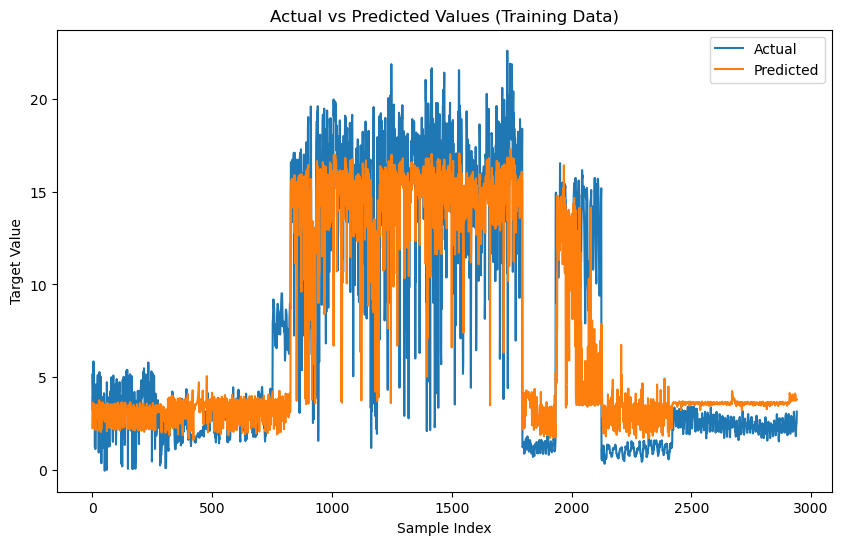

In [36]:
model.eval()

# Predict y_train using the trained model
with torch.no_grad():
    y_train_pred = model(X_train.cuda()).cpu().numpy()

# Inverse transform the predicted y_train_pred back to original scale
y_train_pred_original = scaler_target.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()

# Plot the predicted y_train against the actual y_train
plt.figure(figsize=(10, 6))
plt.plot(y_train1.numpy(), label='Actual')
plt.plot(y_train_pred_original, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values (Training Data)')
plt.legend()
plt.show()

In [37]:
y_train_pred

array([[0.10129837],
       [0.1622512 ],
       [0.1450018 ],
       ...,
       [0.17037466],
       [0.17031655],
       [0.16997902]], dtype=float32)

In [38]:
y_train_pred_original

array([2.2460744, 3.6276586, 3.236676 , ..., 3.8117886, 3.8104713,
       3.802821 ], dtype=float32)

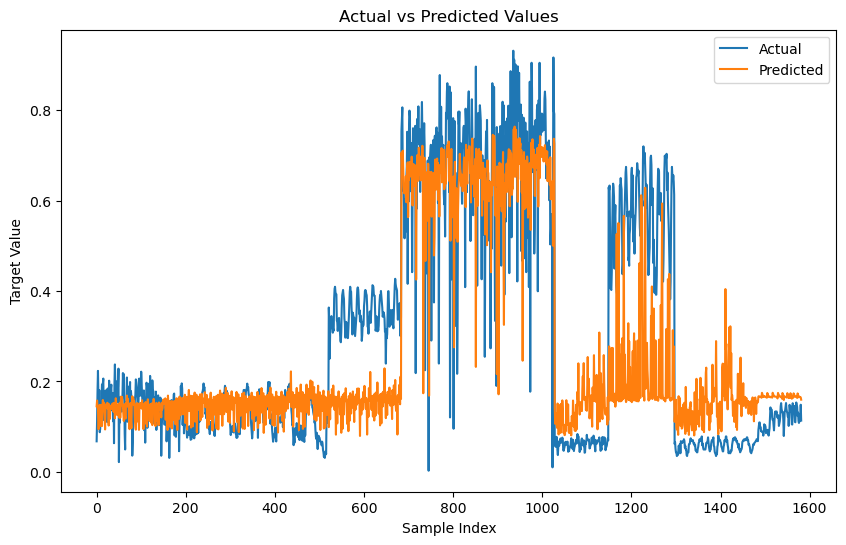

In [39]:
model.eval()

# No gradient calculation needed during inference
with torch.no_grad():
    # Forward pass: compute predicted y by passing X_test to the model
    y_pred = model(X_test)

# Convert tensors to NumPy arrays for easier plotting
y_test_np = y_test.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label='Actual')
plt.plot(y_pred_np, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [40]:
y_pred_np

array([[0.14526774],
       [0.15796448],
       [0.14260893],
       ...,
       [0.16562536],
       [0.16487598],
       [0.15980044]], dtype=float32)

In [41]:
# class SiLevelDataset(Dataset):
#   def __init__(self, sequences):
#     self.sequences = sequences

#   def __len__(self):
#     return len(self.sequences)

#   def __getitem__(self, idx):
#     sequence, label = self.sequences[idx]
#     return dict(
#         sequence = torch.Tensor(sequence.to_numpy()),
#         label = torch.tensor(label).float()
#     )

In [42]:
# class SiLevelDataModule(pl.LightningDataModule):
#   def __init__(
#       self, train_sequences, test_sequences, batch_size = 1
#   ):
#     super().__init__()
#     self.train_sequences = train_sequences
#     self.test_sequences = test_sequences
#     self.batch_size = batch_size
  
#   def setup(self, stage=None):
#     self.train_dataset = SiLevelDataset(self.train_sequences)
#     self.test_dataset = SiLevelDataset(self.test_sequences)
  
#   def train_dataloader(self):
#     return DataLoader(
#         self.train_dataset,
#         batch_size = self.batch_size,
#         shuffle = False,
#         num_workers = 2
#     )

#   def val_dataloader(self):
#     return DataLoader(
#         self.test_dataset,
#         batch_size = 1,
#         shuffle = False,
#         num_workers = 1
#     )
#   def test_dataloader(self):
#     return DataLoader(
#         self.test_dataset,
#         batch_size = 1,
#         shuffle = False,
#         num_workers = 1
#     )

In [43]:
# N_EPOCHS = 8
# BATCH_SIZE = 1

In [44]:
# data_module = SiLevelDataModule(train_sequences_Q1, merged_list_test, batch_size = BATCH_SIZE)
# data_module.setup()

In [45]:
# train_dataset = SiLevelDataset(merged_list_train)
# test_dataset = SiLevelDataset(merged_list_test)

In [46]:
# train_dataset

In [47]:
# a = iter(train_dataset)
# b = next(a)
# print("Sequence Shape: ", b["sequence"].shape)
# print("Label: {} and Label Shape: {}".format(b["label"], b["label"].shape) )